In [2]:
from utilities.preprocessing import *
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import networkx as nx
import igraph as ig
import numba
import itertools
from console_progressbar import ProgressBar


In [3]:
path = '../trending_yt_videos/'

'Import json'
with open(path + 'US_category_id.json') as f:
  videos = json.load(f)

'Save all the categories in dict[id]=category'
categories = {}
for cat in videos['items']:
    # print(cat)
    this_cat = cat['snippet']['title']
    id = cat['id']
    categories[id] = this_cat


In [4]:
len(categories.keys())

32

In [5]:
'Import video dataset:'

video_stats = pd.read_csv(path + 'USvideos.csv')
video_stats = video_stats.replace({'likes':0,'dislikes':0,'comment_count':0},np.nan)
video_stats.dropna(subset=['likes','dislikes','comment_count'],inplace=True)

# EDA

In [6]:
video_stats.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


/tmp/ipykernel_17104/1396074019.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


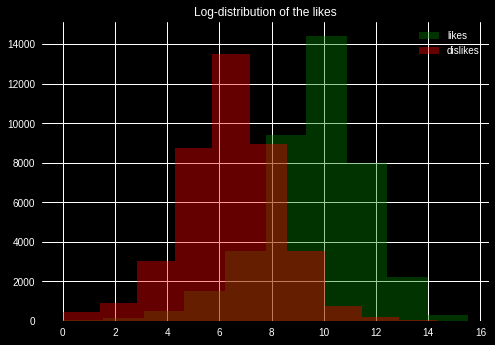

In [277]:
plt.style.use('dark_background')
likes = video_stats.likes#[np.asarray(video_stats.likes != 0)]
dislikes = video_stats.dislikes#[np.asarray(video_stats.dislikes != 0)]
plt.hist(np.log(likes),color = 'green',alpha=0.4,label='likes')
plt.hist(np.log(dislikes),color = 'red',alpha=0.4,label='dislikes')
plt.title('Log-distribution of the likes')
plt.legend()
fig.show()

Text(0.5, 1.0, 'Log distribution of dislikes to likes ratio')

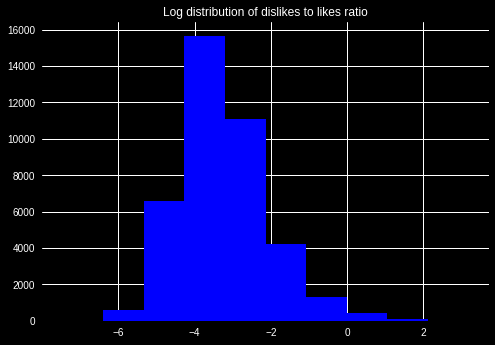

In [278]:
plt.hist(np.log(dislikes/likes),color='blue')
plt.title('Log distribution of dislikes to likes ratio')

Text(0.5, 0.98, 'Log10 distribution of likes & dislikes to views ratios')

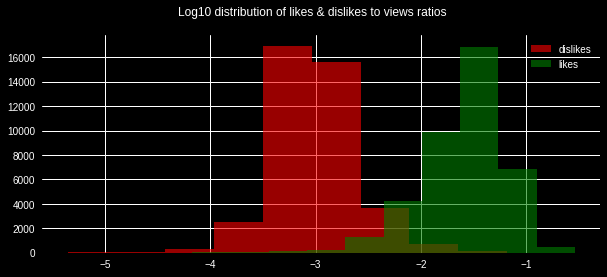

In [279]:
views = video_stats.views[video_stats.views != 0]
fig, ax = plt.subplots(1,1, figsize = (10,4))
ax.hist(np.log10(dislikes/views),color = 'red',label = 'dislikes',alpha=0.6)
# ax.set_xscale('log')
ax.hist(np.log10(likes/views),color = 'green', label = 'likes',alpha=0.6)
# ax.set_xticks(x_ticks)
# ax.set_xticklabels([f'10^({x})' for x in x_ticks])
plt.legend()
plt.suptitle('Log10 distribution of likes & dislikes to views ratios')

Text(0.5, 1.0, 'Log10 distribution of (likes/dislikes)/views')

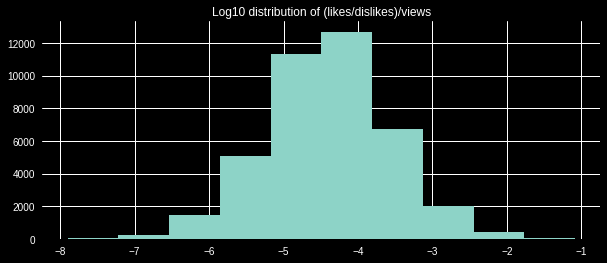

In [280]:
fig, ax = plt.subplots(1,1, figsize = (10,4))
ax.hist(np.log10((likes/dislikes)/(views)))
# ax.set_xscale('log')
# x_ticks = [-4,-3,-2,-1,0]
# ax.set_xticks(x_ticks)
# ax.set_xticklabels([f'10^({x})' for x in x_ticks])
plt.title('Log10 distribution of (likes/dislikes)/views')

In [281]:
set(video_stats.category_id)

{1, 2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 43}

In [282]:
new_col = [categories[f'{id}'] for id in video_stats.category_id]
video_stats['category'] = new_col

In [283]:
video_stats.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172.0,666.0,2146.0,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235.0,1989.0,17518.0,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment


In [292]:
video_stats.tags[3]

'rhett and link|"gmm"|"good mythical morning"|"rhett and link good mythical morning"|"good mythical morning rhett and link"|"mythical morning"|"Season 12"|"nickelback lyrics"|"nickelback lyrics real or fake"|"nickelback"|"nickelback songs"|"nickelback song"|"rhett link nickelback"|"gmm nickelback"|"lyrics (website category)"|"nickelback (musical group)"|"rock"|"music"|"lyrics"|"chad kroeger"|"canada"|"music (industry)"|"mythical"|"gmm challenge"|"comedy"|"funny"|"challenge"'

In [285]:

video_stats['VLratio'] = video_stats.views/video_stats.likes
video_stats['VDratio'] = video_stats.views/video_stats.dislikes
video_stats['LDratio'] = video_stats.likes/video_stats.dislikes
video_stats['VCratio'] = video_stats.views/video_stats.comment_count

video_stats['log10VLratio'] = video_stats.VLratio.apply(np.log10)
video_stats['log10VDratio'] = video_stats.VDratio.apply(np.log10)
video_stats['log10LDratio'] = video_stats.LDratio.apply(np.log10)
video_stats['log10VCratio'] = video_stats.VCratio.apply(np.log10)

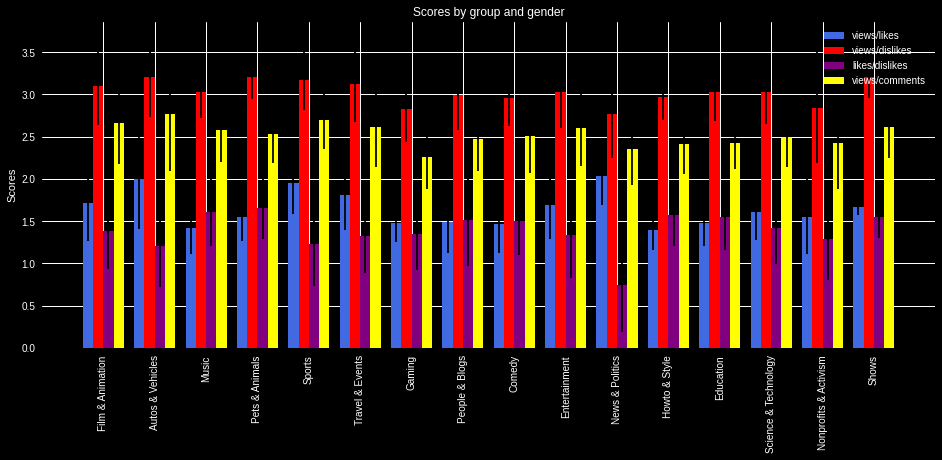

In [291]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')

catmeans = video_stats.groupby('category_id').mean()
catstds = video_stats.groupby('category_id').std()

# likeMeans = catmeans.LVratio
# likeStd =   catstds.LVratio

likeMeans = catmeans.log10VLratio
likeStd =   catstds.log10VLratio

N = len(likeMeans)
ind = np.arange(N)  # the x locations for the groups
width = 0.20      # the width of the bars

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, likeMeans, width, color='royalblue', yerr=likeStd)

dislikeMeans = catmeans.log10VDratio
dislikeStd =   catstds.log10VDratio
# dislikeMeans = np.log10(catmeans.DVratio)
# dislikeStd =   np.log10(catstds.DVratio)

rects2 = ax.bar(ind+width, dislikeMeans, width, color='red', yerr= dislikeStd)

LDMeans = catmeans.log10LDratio
LDStd =   catstds.log10LDratio
# DLMeans = np.log10(catmeans.DLratio)
# DLStd =   np.log10(catstds.DLratio)

rects3 = ax.bar(ind+width*2, LDMeans, width, color='purple', yerr= LDStd)

VCMeans = catmeans.log10VCratio
VCStd = catstds.log10VCratio

rects4 = ax.bar(ind+width*3, VCMeans, width, color='yellow', yerr= VCStd)

# add some
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width*1.5 )
ax.set_xticklabels( [categories[f'{id}'] for id in list(catmeans.index)]) 

ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), 
            ('views/likes', 'views/dislikes','likes/dislikes','views/comments'),
            loc = 'upper right')
plt.xticks(rotation=90)
plt.show()

# NS stuff

In [7]:
friendship_nw = nx.read_weighted_edgelist("../data_sample/edges.csv",delimiter=",")

In [15]:
pd.read_csv('../data_sample/edges.csv')

,Lejla,Antonela,8
0,Lejla,Sulejman,11
1,Lejla,Maja,13
2,Lejla,Lejla S.,11
3,Lejla,Asmira,12
4,Lejla,Amira,8
5,Lejla,Ena,6
6,Antonela,Sulejman,6
7,Antonela,Maja,8
8,Sulejman,Maja,9
9,Lejla S.,Amina,18


In [304]:
G = nx.random_geometric_graph(200,0.125)

TypeError: argmap_random_geometric_graph_1() missing 1 required positional argument: 'radius'

In [298]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [299]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [6]:
g = ig.Graph.from_networkx(friendship_nw)

In [7]:
for vertice in g.vs:
    print(vertice.attributes())
for edge in g.es:
    print(edge.attributes())

{'_nx_name': 'Lejla'}
{'_nx_name': 'Antonela'}
{'_nx_name': 'Sulejman'}
{'_nx_name': 'Maja'}
{'_nx_name': 'Lejla S.'}
{'_nx_name': 'Asmira'}
{'_nx_name': 'Amira'}
{'_nx_name': 'Ena'}
{'_nx_name': 'Amina'}
{'_nx_name': 'Ilma'}
{'_nx_name': 'Nenad'}
{'_nx_name': 'Selma'}
{'_nx_name': 'Naida'}
{'_nx_name': 'Azra'}
{'_nx_name': 'Sneza'}
{'weight': 8.0}
{'weight': 11.0}
{'weight': 13.0}
{'weight': 11.0}
{'weight': 12.0}
{'weight': 8.0}
{'weight': 6.0}
{'weight': 6.0}
{'weight': 8.0}
{'weight': 9.0}
{'weight': 4.0}
{'weight': 9.0}
{'weight': 13.0}
{'weight': 9.0}
{'weight': 18.0}
{'weight': 18.0}
{'weight': 16.0}
{'weight': 16.0}
{'weight': 5.0}
{'weight': 16.0}
{'weight': 18.0}
{'weight': 30.0}


In [ ]:
ig.plot(g)

In [18]:
df = pd.read_csv('../data_sample/networkx-quick-start-master/jira_sample.csv')
df.head()

,Assignee,Reporter,Creator
0,nancy.smith,nancy.smith,nancy.smith
1,nancy.smith,nancy.smith,nancy.smith
2,joe.appleseed,joe.appleseed,joe.appleseed
3,edward.johnson,edward.johnson,edward.johnson
4,adam.apple,joe.appleseed,joe.appleseed


In [19]:
df1 = df[['Assignee','Reporter']]

In [21]:
G =nx.Graph()
G = nx.from_pandas_edgelist(df1,'Assignee','Reporter')

In [ ]:
plt.figure(figsize=(10,8))
nx.draw_shell(G,with_labels=True)

In [24]:
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)

# Creating the graph from the video dataset

In [8]:
import re


In [53]:

# @numba.njit
def build_edgesnodes(videos):
    '''
    ----------------------------------------------------------------------------------------
    Takes a dataframe and returns the list of nodes and edges
    Parameters:
        - videos: dataframe
    ----------------------------------------------------------------------------------------
    '''
    
    pb = ProgressBar(total=100,prefix='Done:', suffix='Now', decimals=0, length=50, fill='#', zfill='-')

    list_of_tags = [videos.channel_title.values[idx] + '|' + videos.tags.values[idx] for idx in range(len(videos))]
    list_of_tags = [re.sub("\"","",tag).split('|') for tag in list_of_tags]

    len_graph = []
    for vg in list_of_tags:
        len_graph.extend(vg)    


    nodes = {node:k for k,node in enumerate(list(set(len_graph)))}
    
    # print(list_of_tags)
    categories = {}
    for row,tags in enumerate(list_of_tags):
        for tag in tags:
            if tag not in categories:
                categories[tag] = [videos.iloc[row].category_id]
            elif tag in categories and videos.iloc[row].category_id not in categories[tag]:
                categories[tag].append(videos.iloc[row].category_id)
        

    len_graph = len(set(len_graph))


    edges = []


    for counter,tags in enumerate(list_of_tags):
        progress = int((counter+1)/len(list_of_tags) * 100)
        pb.print_progress_bar(progress)     
        edges.extend(list(itertools.combinations(tags,2)))
        edges = list(set(edges))
    
    return nodes,edges,categories

In [54]:
%%time

nodes,edges,categories = build_edgesnodes(video_stats.iloc[:1000])

Done: |##################################################| 100% Now
CPU times: user 22.1 s, sys: 291 ms, total: 22.4 s
Wall time: 21.9 s


In [ ]:
# g_test = nx.froms_dict_of_lists(dict_edges)
g_test = nx.from_edgelist(edges)

In [ ]:
# ig.plot(g_test)
plt.figure(figsize=(10,8))
nx.draw_shell(g_test,with_labels=False)

In [ ]:
g = ig.Graph.from_networkx(g_test)
ig.plot(g)

In [21]:
ig.save(g,'graph_test.net',format = 'edgelist')

In [56]:
nodes_df = pd.DataFrame(nodes.keys())
nodes_df['Id'] = nodes.values()
nodes_df.columns = ['Label','Id']
nodes_df['Category'] = [categories[lab] for lab in nodes_df.Label.values]
nodes_df.drop(nodes_df.index[0],inplace=True)
nodes_df = nodes_df.reindex(columns = ['Id','Label','Category'])
pd.DataFrame(nodes_df).to_csv('nodes.csv',index=False)
nodes_df.head()

,Id,Label,Category
1,1,greenhouse effect,[27]
2,2,industry,[26]
3,3,unisex,[23]
4,4,The Rest Of Our Life,[23]
5,5,i have questions,[10]


In [58]:
edges_df = pd.DataFrame([source[0] for source in edges])
edges_df.columns = ['From']
edges_df['To'] = [source[1] for source in edges]
edges_df['Source'] = [nodes[source[0]] for source in edges]
edges_df['Target'] = [nodes[source[1]] for source in edges]
edges_df = edges_df.reindex(columns = ['Source','Target','From','To'])
'Save nodes to nodes.csv'
edges_df.to_csv('edges.csv',index=False)
edges_df.head()

,Source,Target,From,To
0,2930,3060,military vehicle,camping vehicle
1,1322,2665,jillian vessey,playbutton
2,5271,1683,pouch,chlamydia
3,114,3118,action,stake out
4,1689,5797,ketchup shower,gus johnson
